In [1]:
# === Shared setup (run once at top) ===
from pathlib import Path
import pandas as pd, numpy as np, cv2, os, random, time

ROOT    = Path(r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection")
RAW_DIR = ROOT / "data" / "raw_images"          # has 0..9 subfolders
WORK    = ROOT / "workspace"
CROPS_DIR = WORK / "crops_128"                   # normalized crops saved here
SPLITS  = WORK / "splits"
MODELS  = ROOT / "models"
IMG_SIZE = (128,128)                             # (W,H)
RNG_SEED = 42

for d in [WORK, CROPS_DIR, SPLITS, MODELS]: d.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)


ROOT: C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection


In [2]:
import os, cv2, json, shutil, numpy as np, pandas as pd
from pathlib import Path

In [7]:
# ---Square crop + letterbox (to 128x128) ---
import numpy as np, cv2
from pathlib import Path

def make_square_bbox_px(x1,y1,x2,y2, W,H, extra=0.20):
    # coords are normalized [0,1] → pixels
    x1, y1, x2, y2 = int(x1*W), int(y1*H), int(x2*W), int(y2*H)
    cx, cy = (x1+x2)//2, (y1+y2)//2
    side = int(max(x2-x1, y2-y1) * (1.0 + extra))
    x1s = max(0, cx - side//2); y1s = max(0, cy - side//2)
    x2s = min(W, x1s + side);   y2s = min(H, y1s + side)
    if x2s - x1s < side: x1s = max(0, x2s - side)
    if y2s - y1s < side: y1s = max(0, y2s - side)
    return x1s,y1s,x2s,y2s

def letterbox_rgb(rgb, size=(128,128)):
    tw, th = size
    h, w = rgb.shape[:2]
    scale = min(tw/w, th/h)
    nw, nh = int(round(w*scale)), int(round(h*scale))
    resized = cv2.resize(rgb, (nw, nh), interpolation=cv2.INTER_AREA)
    canvas = np.zeros((th, tw, 3), dtype=rgb.dtype)
    top, left = (th-nh)//2, (tw-nw)//2
    canvas[top:top+nh, left:left+nw] = resized
    return canvas

saved = 0
for _, r in bboxes_df.iterrows():
    p, cls = r.path, int(r.cls)
    bgr = cv2.imread(p)
    if bgr is None: continue
    H, W = bgr.shape[:2]
    x1s,y1s,x2s,y2s = make_square_bbox_px(r.x1n, r.y1n, r.x2n, r.y2n, W,H, extra=0.20)
    crop = bgr[y1s:y2s, x1s:x2s]
    if crop.size == 0: continue
    rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    inp = letterbox_rgb(rgb, IMG_SIZE)
    out_dir = CROPS_DIR/str(cls)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir/Path(p).name
    cv2.imwrite(str(out_path), cv2.cvtColor(inp, cv2.COLOR_RGB2BGR))
    saved += 1

print("Saved crops:", saved, "->", CROPS_DIR)


Saved crops: 1717 -> C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\workspace\crops_128


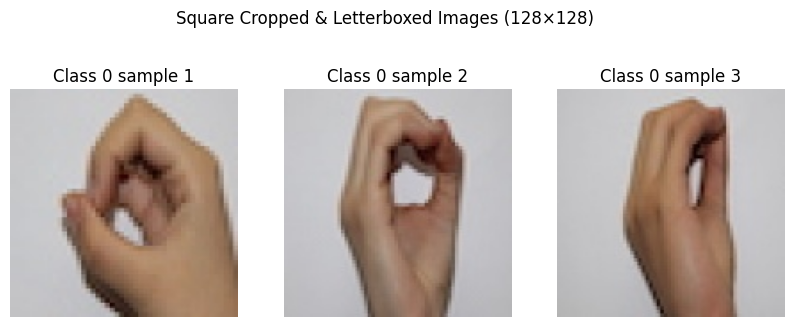

In [9]:
# Preview a few cropped+letterboxed images
import matplotlib.pyplot as plt
import random

sample_paths = list((CROPS_DIR/"0").glob("*"))[:3]  # e.g., take 3 images from class '0'
plt.figure(figsize=(10,4))
for i, p in enumerate(sample_paths, 1):
    img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
    plt.subplot(1,3,i)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Class 0 sample {i}")
plt.suptitle("Square Cropped & Letterboxed Images (128×128)")
plt.show()


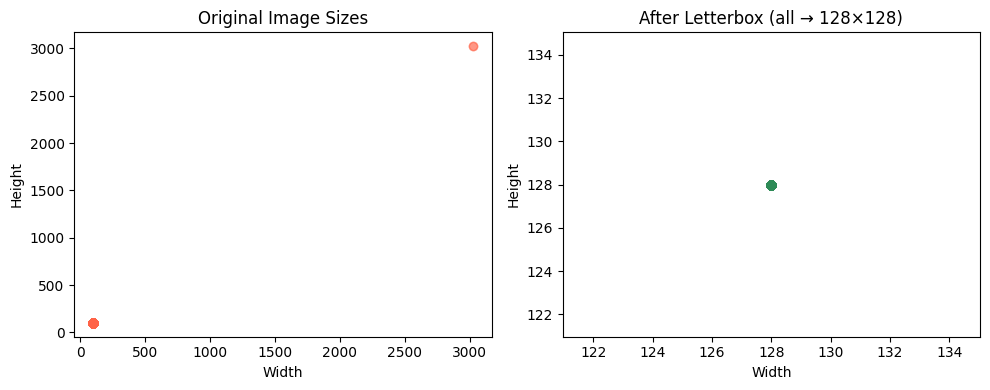

In [10]:
# Compare original sizes vs letterboxed sizes
sizes_before = [cv2.imread(r.path).shape[:2] for _, r in manifest.iterrows()]
sizes_after  = [cv2.imread(str(p)).shape[:2] for p in CROPS_DIR.rglob("*.jpg")]

h_before = [s[0] for s in sizes_before]  # heights
w_before = [s[1] for s in sizes_before]  # widths
h_after  = [s[0] for s in sizes_after]
w_after  = [s[1] for s in sizes_after]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(w_before, h_before, alpha=0.3, color="tomato")
plt.title("Original Image Sizes")
plt.xlabel("Width"); plt.ylabel("Height")

plt.subplot(1,2,2)
plt.scatter(w_after, h_after, alpha=0.5, color="seagreen")
plt.title("After Letterbox (all → 128×128)")
plt.xlabel("Width"); plt.ylabel("Height")

plt.tight_layout()
plt.show()
